# BBC sport News documents Classification

This script is trying to build a predictive model to automatically label the category for each news article. The raw text files are download from http://mlg.ucd.ie/datasets/bbc.html. The main procedure has the following steps:
1. Create a dataframe storing all news data.
2. Clean and preprocess the raw texts (e.g. remove non-words, word stemming). Create training and test datasets.
3. Convert each news article to a feature vector using bag-of-word approach.
4. Build a classification pipeline which includes vectorizer, featureSelection, and classifier. 
5. Train the pipeline with training sets, turn the model parameters.
6. Evaluate the trained model. Apply the optimized model to the test datasets for category prediction. Calculate classifcaition accuracy, consufion matrix.
7. Take some interesting news from BBC website, preprocess them, and input them to optimized model to see how does the model works. 

RESULTS:

Prediction accuracy of Training set: 0.998

Prediction accuracy of Test set: 0.973

In [1]:
# import the Pyton packages
import os
import re
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
sns.set_style('darkgrid')

In [ ]:
# somethings needed to be downloaded from nltk
# import nltk
# nltk.download('stopwords')

## 1. Preparing the data:

### 1) DataFrame creation
Create a DataFrame which include all raw text files.

In [2]:
# change current directory to given path
data_folder = "bbcsport"
folders = ["athletics", "cricket", "football", "rugby", "tennis"]
os.chdir(data_folder)

In [3]:
# read all raw text files, save them as a DataFrame and write into a .csv
title = []
content = []
category = []
category_id = []
filename = []

for i, folder in enumerate(folders):
    files = os.listdir(folder)
    
    for text_file in files:
        file_path = folder + "/" + text_file
        
        print("reading file:", file_path)
        with open(file_path) as f:
            data = f.readlines()
            
        title.append(data[0].strip('\n'))
        
        data = ' '.join(data)
        content.append(data)
        category.append(folder)
        category_id.append(i)
        
    filename += files

df = pd.DataFrame(data=content, columns=['content'])
df['category'] = category
df['category_id'] = category_id
df['title'] = title
df['filename'] = filename
df = df[['category', 'filename', 'title', 'content', 'category_id']]

print('writing csv flie ...')
# df.to_csv('dataset.csv', index=False)

reading file: athletics/001.txt
reading file: athletics/002.txt
reading file: athletics/003.txt
reading file: athletics/004.txt
reading file: athletics/005.txt
reading file: athletics/006.txt
reading file: athletics/007.txt
reading file: athletics/008.txt
reading file: athletics/009.txt
reading file: athletics/010.txt
reading file: athletics/011.txt
reading file: athletics/012.txt
reading file: athletics/013.txt
reading file: athletics/014.txt
reading file: athletics/015.txt
reading file: athletics/016.txt
reading file: athletics/017.txt
reading file: athletics/018.txt
reading file: athletics/019.txt
reading file: athletics/020.txt
reading file: athletics/021.txt
reading file: athletics/022.txt
reading file: athletics/023.txt
reading file: athletics/024.txt
reading file: athletics/025.txt
reading file: athletics/026.txt
reading file: athletics/027.txt
reading file: athletics/028.txt
reading file: athletics/029.txt
reading file: athletics/030.txt
reading file: athletics/031.txt
reading 

reading file: football/076.txt
reading file: football/077.txt
reading file: football/078.txt
reading file: football/079.txt
reading file: football/080.txt
reading file: football/081.txt
reading file: football/082.txt
reading file: football/083.txt
reading file: football/084.txt
reading file: football/085.txt
reading file: football/086.txt
reading file: football/087.txt
reading file: football/088.txt
reading file: football/089.txt
reading file: football/090.txt
reading file: football/091.txt
reading file: football/092.txt
reading file: football/093.txt
reading file: football/094.txt
reading file: football/095.txt
reading file: football/096.txt
reading file: football/097.txt
reading file: football/098.txt
reading file: football/099.txt
reading file: football/100.txt
reading file: football/101.txt
reading file: football/102.txt
reading file: football/103.txt
reading file: football/104.txt
reading file: football/105.txt
reading file: football/106.txt
reading file: football/107.txt
reading 

reading file: rugby/127.txt
reading file: rugby/128.txt
reading file: rugby/129.txt
reading file: rugby/130.txt
reading file: rugby/131.txt
reading file: rugby/132.txt
reading file: rugby/133.txt
reading file: rugby/134.txt
reading file: rugby/135.txt
reading file: rugby/136.txt
reading file: rugby/137.txt
reading file: rugby/138.txt
reading file: rugby/139.txt
reading file: rugby/140.txt
reading file: rugby/141.txt
reading file: rugby/142.txt
reading file: rugby/143.txt
reading file: rugby/144.txt
reading file: rugby/145.txt
reading file: rugby/146.txt
reading file: rugby/147.txt
reading file: tennis/001.txt
reading file: tennis/002.txt
reading file: tennis/003.txt
reading file: tennis/004.txt
reading file: tennis/005.txt
reading file: tennis/006.txt
reading file: tennis/007.txt
reading file: tennis/008.txt
reading file: tennis/009.txt
reading file: tennis/010.txt
reading file: tennis/011.txt
reading file: tennis/012.txt
reading file: tennis/013.txt
reading file: tennis/014.txt
readin

In [4]:
# check the resulting dataframe
df.sample(5, random_state=0)

,category,filename,title,content,category_id
196,cricket,096.txt,England victory tainted by history,England victory tainted by history\n \n As Eng...,1
187,cricket,087.txt,Australia complete sweep,"Australia complete sweep\n \n Third Test, Sydn...",1
14,athletics,015.txt,UK Athletics agrees new kit deal,UK Athletics agrees new kit deal\n \n UK Athle...,0
31,athletics,032.txt,Bekele sets sights on world mark,Bekele sets sights on world mark\n \n Olympic ...,0
545,rugby,056.txt,Captains lining up for Aid match,Captains lining up for Aid match\n \n Ireland'...,3


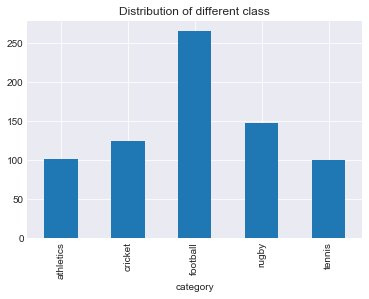

In [5]:
# check the class distribution
df.groupby('category')['title'].count().plot.bar(ylim=0)
plt.title('Distribution of different class');

The distribution of different categories are not imbalanced. If one category occupy a great portion, say 90%, then I think the dataset is imbalanced, which does not apply to current situation, so no worries.

### 2) Preprocess the news content
Basically remove non-words and word stemming.

Non-words removal means remove the numbers, alphabets, punctuations, symbols.

In [6]:
# function for remove non-words
def remove_nonwords(string):
    string = re.sub(r"\'s", "", string)
    string = re.sub(r"\'ve", "", string)
    string = re.sub(r"n\'t", "", string)
    string = re.sub(r"\'re", "", string)
    string = re.sub(r"\'d", "", string)
    string = re.sub(r"\'ll", "", string)
    string = re.sub(r",", "", string)
    string = re.sub(r"!", "", string)
    string = re.sub(r"\(", "", string)
    string = re.sub(r"\)", "", string)
    string = re.sub(r"\?", "", string)
    string = re.sub(r"'", "", string)
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"[0-9]\w+|[0-9]","", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

Word stemming means words are reduced to their stemmed form. For example, “discount”, “discounts”, “discounted” and “discounting” are all replaced with “discount”. **SnowballStemmer** of **nltk** library will be used for stemming purpose.

In [7]:
# apply non-word removal and word stemming on the original news content
stemmer = SnowballStemmer('english')
words = stopwords.words('english')
df['cleaned'] = df['content'].apply(lambda x: ' '.join([stemmer.stem(i) for i in remove_nonwords(x).split() if i not in words]))

## 2. Machine learning:

### 1) Create training and test sets

In [8]:
# 80% of data for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(df['cleaned'], df['category_id'], test_size=0.2, random_state=0)

### 2) Convert news article to vector
Each news article must be transformed to a feature vector in order to be processed by a ML model. One common approach is bag-of-word, which consider the frequency of words presence in the articles and ignore the order in which the words occur.

**TfidfVectorizer** of **scikit-learn** library will be used to vectorize each news text. Usually, **TfidfVectorizer** take all unique words in the whole dataset(which having many articles) except stopwords as features when building a vocabulary list. A unique word is a feature. Stopwords like 'the', 'is', 'are' occur in every news article and they can't be used as signitures to differentiate different categories, so stopwords won't be used as features. 

The **TfidfVectorizer** actually perform two things: **CountVectorizer** and **TfidTransformer**. The **CountVectorizer** count the number of presence for every single word, this calculate the word feaquency. Then the **TfidTransformer** give each feature a weighting as it takes the document frequency of each feature into account. As a result, words like 'they', 'have', 'he', 'she' appearing in many documents will have a lower weight because they are quite common and not related to a certain category. Words like 'singer', 'online', 'government' appearing in less articles will have a higher weight becaue they are more relevant to the category of news. So **TfidfVectorizer** calculate a value for each feature by taking both word frequency and document fequency into consideration.

Important parameters of **TfidfVectorizer**:

**sublinear_tf**: often set to True to take the logarithmic form for frequency.

**min_df**: set a threshold, so a unique word won't be used as a feature if it's document feaquency lower than this threshold. (will be turned in model training)

**ngram_range**: setting this parameter enable n-consecutive words to be considered as one feature in addition to the rule of one word as one feature. For example, if ngram_range=(1, 2), not only 'tennis' and 'player' but also 'tennis player' are features. (will be turned in model training)

**stop_words**: set to be 'english' according to the language of current data.

In [9]:
# extracting features from the training data using TfidfVectorizer
TfidVect = TfidfVectorizer(sublinear_tf=True, min_df=1, ngram_range=(1, 1), stop_words='english')
X_train_vect = TfidVect.fit_transform(X_train).toarray()
X_train_vect.shape

(589, 8073)

There are 589 news articles in the training set. Each news article is now represented by a 8073-length feature vector.

### 3) PCA 
Plot the data in a 2D plane is a good way to visualize how seperate between different classes. Since the dimension of Tfidfvectors is very high, PCA is used to project the data into a 2D plane whose two coordinate axes are the first and second principle components.

In [10]:
# apply PCA transformation
pca = PCA(n_components = 2).fit(X_train_vect)
X_pca = pca.transform(X_train_vect)
print(X_train_vect.shape, X_pca.shape)

(589, 8073) (589, 2)


After PCA, the dimension of the data is reduced from 589 to 2. Please note that this PCA is used only for data visualization but not classification, so we create X_train_vect and keep X_train unchanged.

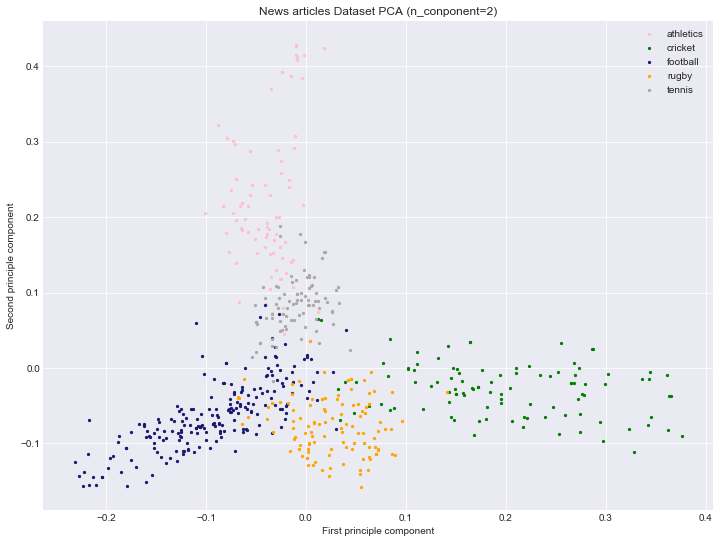

In [11]:
# plot the news dataset in 2D
f, ax = plt.subplots(figsize=(12, 9))
colors = ['pink', 'green', 'midnightblue', 'orange', 'darkgrey']
for category_id, category in enumerate(folders):
    points = X_pca[[y_train == category_id]]
    plt.scatter(points[:, 0], points[:, 1], s=5, c=colors[category_id], label=category)
    
plt.xlabel('First principle component')
plt.ylabel('Second principle component')
plt.title('News articles Dataset PCA (n_conponent=2)')    
plt.legend();

It appear that this dataset is linearly separable. So I expect a linear classifier will works well.

### 4) Build a predictive model 
I build a pipeline which include newsVectorization, featureSelection, and classification all in one. First, the news raw texts will be converted to Tfidfvectors. Second a number of best features will be selected by **SelectKBest**. Third, the selected features will be used in the classification.

The best k features are selected using chi-square test. The chi-squared stats measure the dependence between each non-negative feature and the categories. Higher chi-squared stats value indicate higher correlation between a certain feature and a certain category. So features which are independent of the category will be filtered out. Parameter **k** will be turned in model training.

Support Vector Machine (SVM) with linear kernel will be used in classification. Linear SVM make an assumption that the training data is linearly saparable, this assumption is in line with the observation in the previous PCA plot. In addition, linear SVM aim at searching for maximum amount of margin between classes. 

Important parameters of Linear SVM:

**C**: control how much regularization. Smaller C, more regularization, encourage the classifier to find the large margin decision boundary, even this margin lead to more training samples mis-classify.  Large C,less regularization,classify the training data as good as possible, even use smaller margin decision boundary. (will be turned in the model training)

**penalty**: 'l1' use Lasso regularization, 'l2' use Ridge regularization. I test this parameter outside this script and find 'l2' perform better.

**dual**: Prefer dual=False when n_samples > n_features.

In [12]:
# create a pipeline
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(sublinear_tf=True, stop_words='english')), 
    ('featSelect', SelectKBest(chi2)), 
    ('classifier', LinearSVC(penalty='l2', max_iter=1000, dual=False))
])

In [13]:
# calculate the cross-validation accuracy of a baseline classifier
scores = cross_val_score(pipeline, X_train, y_train, scoring = 'accuracy', cv=10)
scores.mean()

0.79213918062539057

Accuracy score of the baseline classifier is 0.792, and the default k=10 (e.g. using 10 selected features) leads to a good score.

In [14]:
# parameters to be turned for model improvement
grid_values = {
    'vectorizer__min_df': [1, 5],
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    'featSelect__k': [50, 200],
    'classifier__C': [1.0, 0.8],
}

In [15]:
# Search for optimal set of parameters, 10-fold cross-validation 
grid_search = GridSearchCV(pipeline, param_grid = grid_values, scoring = 'accuracy', cv=10)

# train the model on training data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=Tr...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'vectorizer__min_df': [1, 5], 'vectorizer__ngram_range': [(1, 1), (1, 2)], 'featSelect__k': [50, 200], 'classifier__C': [1.0, 0.8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [16]:
# print the highest accuracy and the corresponding parameters
print(grid_search.best_score_)
print(grid_search.best_params_)

0.989813242784
{'classifier__C': 1.0, 'featSelect__k': 200, 'vectorizer__min_df': 5, 'vectorizer__ngram_range': (1, 1)}


In [17]:
# build a pipeline with optimized parameters
pipeline_opt = Pipeline([
    ('vectorizer', TfidfVectorizer(sublinear_tf=True, min_df=5, ngram_range=(1, 1), stop_words='english')), 
    ('featSelect', SelectKBest(chi2, k=200)), 
    ('classifier', LinearSVC(C=1.0, penalty='l2', max_iter=1000, dual=False))
])

In [18]:
# calculate the desicion boundary 
model = pipeline_opt.fit(X_train, y_train)

In [19]:
# main components of the pipeline
vectorizer = model.named_steps['vectorizer']
chi = model.named_steps['featSelect']
clf = model.named_steps['classifier']

In [20]:
# list the 500 best features(keywords) selected using chi-squared test
feature_names = vectorizer.get_feature_names()
feature_names = [feature_names[i] for i in chi.get_support(indices=True)]  
feature_names = np.asarray(feature_names)
feature_names

array(['aaa', 'africa', 'agassi', 'akhtar', 'american', 'arsenal', 'ash',
       'athen', 'athlet', 'australia', 'australian', 'balco', 'ban',
       'bangladesh', 'bat', 'bath', 'batsman', 'batsmen', 'beat', 'bekel',
       'belgian', 'birmingham', 'boje', 'boss', 'boundari', 'bowl',
       'bowler', 'britain', 'british', 'broke', 'bronz', 'capt', 'centuri',
       'charli', 'chelsea', 'chepkemei', 'clijster', 'club', 'collin',
       'commonwealth', 'compet', 'cont', 'counti', 'cricket', 'dallaglio',
       'davenport', 'deliveri', 'dementieva', 'dent', 'dope', 'drug',
       'dubai', 'elena', 'england', 'european', 'event', 'fa', 'feder',
       'flanker', 'fli', 'flintoff', 'footbal', 'franc', 'franci',
       'garden', 'gb', 'gile', 'goal', 'gold', 'grand', 'greek',
       'hantuchova', 'harmison', 'henman', 'henson', 'hewitt', 'hodgson',
       'holm', 'hopman', 'hurdl', 'iaaf', 'icc', 'indi', 'india', 'indoor',
       'inning', 'ireland', 'isinbayeva', 'itali', 'ivan', 'johansso

In [21]:
# List top 10 keywords for eahc categories
target_names = folders
print('Top 10 keywords per class:')
for i, label in enumerate(target_names):
    top10 = np.argsort(clf.coef_[i])[-10:]
    print(label + ': ' + ', '.join(feature_names[top10]))

Top 10 keywords per class:
athletics: medal, radcliff, sprinter, mcilroy, marathon, european, indoor, race, athlet, olymp
cricket: vaughan, australia, pakistan, wkt, test, pont, icc, seri, wicket, cricket
football: boss, striker, fa, arsenal, unit, manag, club, chelsea, goal, footbal
rugby: wing, itali, ireland, wasp, scotland, flanker, nation, wale, saracen, rugbi
tennis: henman, rusedski, wimbledon, nadal, number, australian, open, roddick, seed, tenni


These top keywords used by the model for prediction are quite sensible.

If an unseen news article have similar characteristics with the previous training data, the model should correctly predict the category for this unseen article. However, if the unseen article is very different from the previous training set, the model may not be able to provide an accurate prediction. Therefore, the model should continuely be trained with new unseen data so as to adapt it's parameters overtime and continue to prove useful prediction. Use online learning.

## 3. Evaluation

In [22]:
# calculate accuracy
print('accuracy score_Training: ' + str(model.score(X_train, y_train)))
print('accuracy score_Test: ' + str(model.score(X_test, y_test)))

accuracy score_Training: 0.998302207131
accuracy score_Test: 0.972972972973


The model perform quite well with prediction accuracy equals to 0.973 .

In [23]:
# calculate prediction for test set
y_predict_test = model.predict(X_test)

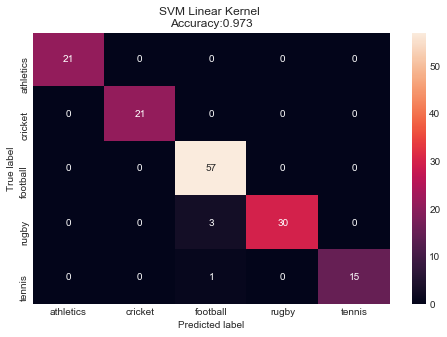

In [24]:
# calculate confusion matrix
f, ax = plt.subplots(figsize=(8, 5))
conf_mat = confusion_matrix(y_test, y_predict_test)
sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=folders, yticklabels=folders)           
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('SVM Linear Kernel \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_predict_test)));

### Make prediction for today's news
Unseen_news_3 is from: https://www.bbc.co.uk/sport/football/45543033

Unseen_news_4 is from: https://www.bbc.co.uk/sport/rugby-union/45489775

In [29]:
# collect and preprocess data
file_path = 'Unseen_news_4.txt'
with open(file_path) as f:
    data = f.readlines()   
    
X_forPredict_orig = ' '.join(data)
X_forPredict_cleaned = ' '.join([stemmer.stem(i) for i in remove_nonwords(X_forPredict_orig).split() if i not in words])

In [30]:
X_forPredict_orig

"Premiership: Wasps 41-35 Leicester Tigers\n \n Wasps resisted a courageous second-half display by 14-man Leicester Tigers to earn a narrow victory in a captivating eight-try game at the Ricoh Arena.\n \n Scores by Juan de Jongh and Josh Bassett saw Wasps race 14-0 ahead.\n \n Tigers hit back to trail 25-18, but the controversial dismissal of Will Spencer for a dangerous tackle turned the game heavily in Wasps' favour by the break.\n \n Johnny May's second try helped put Tigers ahead but three Lima Sopoaga kicks sealed victory for the hosts.\n \n Sopoaga's reliability with the boot ultimately proved the difference as the sides each picked up a bonus point for registering four tries in a thrilling, open, contest enriched by some dubious defending.\n \n Relive Wasps v Leicester as it happened\n But Spencer's red card, so soon after the Tigers got back to within seven points of their hosts, was a telling moment.\n \n The Leicester second-rower was adjudged to have gone high into a challen

In [31]:
X_forPredict_cleaned

'premiership wasp leicest tiger wasp resist courag second half display man leicest tiger earn narrow victori captiv eight tri game ricoh arena score juan de jongh josh bassett saw wasp race ahead tiger hit back trail controversi dismiss spencer danger tackl turn game heavili wasp favour break johnni may second tri help put tiger ahead three lima sopoaga kick seal victori host sopoaga reliabl boot ultim prove differ side pick bonus point regist four tri thrill open contest enrich dubious defend reliv wasp v leicest happen spencer red card soon tiger got back within seven point host tell moment leicest second rower adjudg gone high challeng wasp hooker tommi taylor made contact head shoulder de jongh gone open score dan robson took advantag fortun break run deep half bassett collect elliot dali fine kick score corner nathan hugh bundl gareth owen knock third home score georg ford set tri may astut kick telusa veainu tiger pack start rattl wasp interv result sion kalamafoni close rang eff

In [32]:
print('The category of this news is predicted as: ' + folders[model.predict([X_forPredict_cleaned])[0]]) 

The category of this news is predicted as: rugby


This model provide correct prediction for today's news.

## 4. Conclusions
In this script, a preditive model for automatic bbcsport news classification is developed and evaluated. The process pipeline include: (1) clean the raw text data; (2) extract tf-idf features from cleaned text; (3) select best features using chi-square test; (4) train and apply the linear SVM model to predict the category for unseen news documents. Optimal setting is seached by turning the important parameters of the model, obtaining a classification accuracy of 97%.

In future, it would be interesting to try out different classifiers, such as Random Forest, Gradient Boosting Trees, etc. 

## 5. References

http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer

http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html#sklearn.feature_selection.chi2

http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html

http://scikit-learn.org/stable/auto_examples/text/document_classification_20newsgroups.html#sphx-glr-auto-examples-text-document-classification-20newsgroups-py

https://cloud.google.com/blog/products/gcp/problem-solving-with-ml-automatic-document-classification

https://github.com/suraj-deshmukh/BBC-Dataset-News-Classification

https://github.com/giuseppebonaccorso/bbc_news_classification_comparison/blob/master/BBC%20News%20classification%20comparison.ipynb

https://www.youtube.com/watch?v=5xDE06RRMFk&ab_channel=Coding-Maniac

https://www.youtube.com/watch?v=CArkneSPNr4&ab_channel=Coding-Maniac

https://textminingonline.com/dive-into-nltk-part-iv-stemming-and-lemmatization